Isotropic Total Variation
=========================

This example demonstrates isotropic total variation (TV)
regularization. It solves the denoising problem

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - \mathbf{x}
  \|^2 + \lambda R(\mathbf{x}) \;,$$

where $R$ is the isotropic TV: the sum of the norms of the gradient
vectors at each point in the image $\mathbf{x}$. The same
reconstruction is performed with anisotropic TV regularization for
comparison; the isotropic version shows fewer block-like artifacts.

In SCICO, switching between these two regularizers is a one-line
change: replacing an
[L1Norm](../_autosummary/scico.functional.rst#scico.functional.L1Norm)
with a
[L21Norm](../_autosummary/scico.functional.rst#scico.functional.L21Norm).

In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp

from scico import functional, linop, loss, plot
from scico.admm import ADMM, LinearSubproblemSolver
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 256  # image size

# Create a ground truth image by spatially filtering noise.
kernel_size = N // 5
key = jax.random.PRNGKey(1)
x_gt = jax.random.uniform(key, shape=(N + kernel_size - 1, N + kernel_size - 1))
x = jnp.linspace(-3, 3, kernel_size)
window = jsp.stats.norm.pdf(x) * jsp.stats.norm.pdf(x[:, None])
window = window / window.sum()
x_gt = jsp.signal.convolve(x_gt, window, mode="valid")
x_gt = (x_gt > jnp.percentile(x_gt, 25)).astype(float) + (x_gt > jnp.percentile(x_gt, 75)).astype(
    float
)
x_gt = x_gt / x_gt.max()

Add noise to create a noisy test image.

In [3]:
σ = 1.0  # noise standard deviation
key, subkey = jax.random.split(key)
n = σ * jax.random.normal(subkey, shape=x_gt.shape)
y = x_gt + n

Denoise with isotropic total variation

In [4]:
reg_weight_iso = 2e0
f = loss.SquaredL2Loss(y=y)
g_iso = reg_weight_iso * functional.L21Norm()

# The append=0 option makes the results of horizontal and vertical finite
# differences the same shape, which is required for the L21Norm.
C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
solver = ADMM(
    f=f,
    g_list=[g_iso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 20}),
    verbose=True,
)

solver.solve()

x_iso = solver.x

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  2.28e+00  2.025e+05    5.106e+01  1.059e+02
   1  3.02e+00  1.841e+05    4.301e+00  1.003e+02
   2  3.04e+00  1.646e+05    4.233e+00  9.701e+01
   3  3.06e+00  1.466e+05    4.915e+00  9.344e+01
   4  3.08e+00  1.300e+05    5.615e+00  8.955e+01


   5  3.11e+00  1.150e+05    6.206e+00  8.536e+01
   6  3.14e+00  1.015e+05    6.733e+00  8.089e+01
   7  3.16e+00  8.947e+04    7.014e+00  7.621e+01
   8  3.18e+00  7.894e+04    7.411e+00  7.125e+01
   9  3.21e+00  6.986e+04    7.684e+00  6.605e+01
  10  3.23e+00  6.219e+04    7.914e+00  6.065e+01
  11  3.25e+00  5.584e+04    8.023e+00  5.506e+01
  12  3.28e+00  5.070e+04    7.951e+00  4.950e+01
  13  3.30e+00  4.662e+04    7.654e+00  4.403e+01


  14  3.33e+00  4.348e+04    7.446e+00  3.871e+01
  15  3.35e+00  4.112e+04    7.003e+00  3.362e+01
  16  3.37e+00  3.938e+04    6.430e+00  2.898e+01
  17  3.40e+00  3.811e+04    5.802e+00  2.479e+01
  18  3.42e+00  3.721e+04    5.235e+00  2.099e+01
  19  3.44e+00  3.658e+04    4.603e+00  1.777e+01
  20  3.47e+00  3.614e+04    4.021e+00  1.508e+01
  21  3.49e+00  3.585e+04    3.583e+00  1.268e+01
  22  3.51e+00  3.566e+04    3.149e+00  1.063e+01


  23  3.54e+00  3.553e+04    2.756e+00  8.910e+00
  24  3.56e+00  3.545e+04    2.391e+00  7.461e+00
  25  3.59e+00  3.540e+04    2.131e+00  6.229e+00
  26  3.61e+00  3.537e+04    1.840e+00  5.244e+00
  27  3.63e+00  3.536e+04    1.617e+00  4.463e+00
  28  3.66e+00  3.535e+04    1.427e+00  3.764e+00
  29  3.68e+00  3.535e+04    1.305e+00  3.170e+00
  30  3.71e+00  3.535e+04    1.136e+00  2.701e+00
  31  3.73e+00  3.536e+04    1.048e+00  2.262e+00


  32  3.75e+00  3.536e+04    9.495e-01  1.902e+00
  33  3.78e+00  3.537e+04    8.566e-01  1.563e+00
  34  3.80e+00  3.537e+04    8.057e-01  1.209e+00
  35  3.83e+00  3.538e+04    7.303e-01  8.882e-01
  36  3.85e+00  3.538e+04    6.351e-01  7.826e-01
  37  3.87e+00  3.539e+04    5.792e-01  6.930e-01
  38  3.90e+00  3.539e+04    5.443e-01  6.072e-01
  39  3.92e+00  3.540e+04    5.164e-01  4.928e-01
  40  3.94e+00  3.540e+04    4.723e-01  4.499e-01


  41  3.97e+00  3.540e+04    4.448e-01  4.119e-01
  42  3.99e+00  3.541e+04    4.197e-01  3.795e-01
  43  4.02e+00  3.541e+04    3.965e-01  3.506e-01
  44  4.04e+00  3.541e+04    3.749e-01  3.247e-01
  45  4.07e+00  3.542e+04    3.559e-01  2.912e-01
  46  4.09e+00  3.542e+04    3.401e-01  2.527e-01
  47  4.11e+00  3.542e+04    3.240e-01  2.249e-01
  48  4.14e+00  3.542e+04    3.082e-01  2.057e-01
  49  4.16e+00  3.542e+04    2.933e-01  1.908e-01


  50  4.18e+00  3.542e+04    2.798e-01  1.770e-01
  51  4.21e+00  3.543e+04    2.674e-01  1.652e-01
  52  4.23e+00  3.543e+04    2.563e-01  1.547e-01
  53  4.26e+00  3.543e+04    2.457e-01  1.457e-01
  54  4.28e+00  3.543e+04    2.356e-01  1.380e-01
  55  4.30e+00  3.543e+04    2.262e-01  1.306e-01
  56  4.33e+00  3.543e+04    2.174e-01  1.232e-01
  57  4.35e+00  3.543e+04    2.089e-01  1.174e-01


  58  4.39e+00  3.543e+04    2.007e-01  1.127e-01
  59  4.43e+00  3.544e+04    1.931e-01  1.078e-01
  60  4.46e+00  3.544e+04    1.862e-01  1.015e-01
  61  4.49e+00  3.544e+04    1.797e-01  9.481e-02
  62  4.53e+00  3.544e+04    1.737e-01  8.898e-02
  63  4.56e+00  3.544e+04    1.678e-01  8.391e-02
  64  4.59e+00  3.544e+04    1.621e-01  7.982e-02


  65  4.62e+00  3.544e+04    1.564e-01  7.600e-02
  66  4.65e+00  3.544e+04    1.510e-01  7.338e-02
  67  4.68e+00  3.544e+04    1.460e-01  7.084e-02
  68  4.71e+00  3.544e+04    1.412e-01  6.854e-02
  69  4.74e+00  3.544e+04    1.365e-01  6.665e-02
  70  4.78e+00  3.544e+04    1.321e-01  6.399e-02
  71  4.81e+00  3.544e+04    1.283e-01  6.010e-02


  72  4.85e+00  3.544e+04    1.247e-01  5.625e-02
  73  4.89e+00  3.544e+04    1.210e-01  5.373e-02
  74  4.96e+00  3.544e+04    1.174e-01  5.200e-02
  75  5.01e+00  3.544e+04    1.139e-01  5.000e-02


  76  5.05e+00  3.544e+04    1.107e-01  4.820e-02
  77  5.09e+00  3.545e+04    1.076e-01  4.635e-02
  78  5.13e+00  3.545e+04    1.045e-01  4.490e-02
  79  5.18e+00  3.545e+04    1.014e-01  4.344e-02
  80  5.22e+00  3.545e+04    9.868e-02  4.113e-02


  81  5.26e+00  3.545e+04    9.599e-02  3.946e-02
  82  5.29e+00  3.545e+04    9.349e-02  3.732e-02
  83  5.34e+00  3.545e+04    9.108e-02  3.554e-02
  84  5.38e+00  3.545e+04    8.889e-02  3.373e-02
  85  5.42e+00  3.545e+04    8.685e-02  3.238e-02


  86  5.47e+00  3.545e+04    8.484e-02  3.167e-02
  87  5.50e+00  3.545e+04    8.294e-02  3.076e-02
  88  5.53e+00  3.545e+04    8.110e-02  2.974e-02
  89  5.56e+00  3.545e+04    7.935e-02  2.843e-02
  90  5.59e+00  3.545e+04    7.766e-02  2.742e-02
  91  5.62e+00  3.545e+04    7.594e-02  2.636e-02
  92  5.66e+00  3.545e+04    7.431e-02  2.500e-02


  93  5.69e+00  3.545e+04    7.275e-02  2.381e-02
  94  5.71e+00  3.545e+04    7.126e-02  2.279e-02
  95  5.74e+00  3.545e+04    6.973e-02  2.239e-02
  96  5.76e+00  3.545e+04    6.829e-02  2.179e-02
  97  5.79e+00  3.545e+04    6.694e-02  2.145e-02
  98  5.81e+00  3.545e+04    6.561e-02  2.124e-02
  99  5.83e+00  3.545e+04    6.439e-02  2.073e-02


Denoise with anisotropic total variation for comparison.

In [5]:
# Tune the weight to give the same data fidelty as the isotropic case.
reg_weight_aniso = 1.74e0
g_aniso = reg_weight_aniso * functional.L1Norm()

solver = ADMM(
    f=f,
    g_list=[g_aniso],
    C_list=[C],
    rho_list=[1e1],
    x0=y,
    maxiter=100,
    subproblem_solver=LinearSubproblemSolver(cg_kwargs={"maxiter": 20}),
    verbose=True,
)

solver.solve()

x_aniso = solver.x

Iter  Time      Objective  Primal Rsdl  Dual Rsdl
-------------------------------------------------
   0  3.37e-01  2.197e+05    6.090e+01  1.236e+02
   1  5.36e-01  1.974e+05    9.715e+00  1.161e+02
   2  5.69e-01  1.728e+05    1.055e+01  1.103e+02
   3  5.98e-01  1.507e+05    1.097e+01  1.043e+02
   4  6.27e-01  1.309e+05    1.102e+01  9.830e+01
   5  6.56e-01  1.135e+05    1.102e+01  9.215e+01
   6  6.78e-01  9.825e+04    1.100e+01  8.590e+01
   7  7.03e-01  8.509e+04    1.098e+01  7.950e+01


   8  7.33e-01  7.392e+04    1.090e+01  7.301e+01
   9  7.62e-01  6.467e+04    1.087e+01  6.623e+01
  10  7.91e-01  5.719e+04    1.064e+01  5.939e+01
  11  8.20e-01  5.131e+04    1.026e+01  5.250e+01
  12  8.49e-01  4.680e+04    9.628e+00  4.592e+01
  13  8.78e-01  4.342e+04    8.922e+00  3.975e+01
  14  9.06e-01  4.096e+04    8.125e+00  3.404e+01


  15  9.39e-01  3.918e+04    7.209e+00  2.889e+01
  16  9.69e-01  3.793e+04    6.389e+00  2.436e+01
  17  9.99e-01  3.707e+04    5.615e+00  2.040e+01
  18  1.03e+00  3.648e+04    4.779e+00  1.725e+01
  19  1.06e+00  3.607e+04    4.119e+00  1.462e+01
  20  1.09e+00  3.580e+04    3.589e+00  1.239e+01
  21  1.12e+00  3.562e+04    3.196e+00  1.041e+01


  22  1.15e+00  3.551e+04    2.762e+00  8.655e+00
  23  1.18e+00  3.544e+04    2.499e+00  7.127e+00
  24  1.21e+00  3.539e+04    2.056e+00  6.086e+00
  25  1.24e+00  3.537e+04    1.797e+00  5.254e+00
  26  1.27e+00  3.536e+04    1.609e+00  4.449e+00
  27  1.30e+00  3.535e+04    1.440e+00  3.721e+00
  28  1.33e+00  3.535e+04    1.301e+00  3.129e+00


  29  1.36e+00  3.535e+04    1.159e+00  2.650e+00
  30  1.39e+00  3.536e+04    1.049e+00  2.246e+00
  31  1.42e+00  3.536e+04    9.522e-01  1.860e+00
  32  1.45e+00  3.537e+04    8.667e-01  1.547e+00
  33  1.48e+00  3.537e+04    8.026e-01  1.225e+00
  34  1.51e+00  3.538e+04    7.067e-01  1.069e+00
  35  1.54e+00  3.538e+04    6.370e-01  1.000e+00


  36  1.58e+00  3.539e+04    5.925e-01  9.024e-01
  37  1.61e+00  3.539e+04    5.538e-01  7.997e-01
  38  1.64e+00  3.539e+04    5.163e-01  7.333e-01
  39  1.67e+00  3.539e+04    4.772e-01  6.905e-01
  40  1.70e+00  3.540e+04    4.480e-01  6.492e-01
  41  1.72e+00  3.540e+04    4.282e-01  5.699e-01
  42  1.75e+00  3.540e+04    4.046e-01  5.147e-01


  43  1.78e+00  3.541e+04    3.817e-01  4.775e-01
  44  1.81e+00  3.541e+04    3.601e-01  4.474e-01
  45  1.84e+00  3.541e+04    3.411e-01  4.196e-01
  46  1.87e+00  3.541e+04    3.229e-01  3.962e-01
  47  1.90e+00  3.541e+04    3.061e-01  3.757e-01
  48  1.93e+00  3.541e+04    2.911e-01  3.556e-01
  49  1.95e+00  3.541e+04    2.770e-01  3.370e-01
  50  1.98e+00  3.541e+04    2.638e-01  3.190e-01


  51  2.01e+00  3.542e+04    2.512e-01  3.034e-01
  52  2.03e+00  3.542e+04    2.396e-01  2.886e-01
  53  2.05e+00  3.542e+04    2.289e-01  2.737e-01
  54  2.08e+00  3.542e+04    2.188e-01  2.594e-01
  55  2.10e+00  3.542e+04    2.092e-01  2.459e-01
  56  2.12e+00  3.542e+04    1.994e-01  2.344e-01
  57  2.15e+00  3.542e+04    1.902e-01  2.243e-01
  58  2.17e+00  3.542e+04    1.817e-01  2.148e-01
  59  2.20e+00  3.542e+04    1.739e-01  2.056e-01


  60  2.23e+00  3.542e+04    1.669e-01  1.961e-01
  61  2.25e+00  3.542e+04    1.607e-01  1.866e-01
  62  2.27e+00  3.542e+04    1.544e-01  1.781e-01
  63  2.29e+00  3.542e+04    1.487e-01  1.696e-01
  64  2.32e+00  3.542e+04    1.435e-01  1.606e-01
  65  2.34e+00  3.542e+04    1.383e-01  1.526e-01
  66  2.36e+00  3.543e+04    1.335e-01  1.453e-01
  67  2.39e+00  3.543e+04    1.291e-01  1.379e-01
  68  2.41e+00  3.543e+04    1.247e-01  1.310e-01


  69  2.44e+00  3.543e+04    1.206e-01  1.242e-01
  70  2.46e+00  3.543e+04    1.169e-01  1.179e-01
  71  2.48e+00  3.543e+04    1.128e-01  1.138e-01
  72  2.51e+00  3.543e+04    1.087e-01  1.104e-01
  73  2.54e+00  3.543e+04    1.050e-01  1.061e-01
  74  2.57e+00  3.543e+04    1.015e-01  1.023e-01
  75  2.60e+00  3.543e+04    9.795e-02  9.935e-02
  76  2.63e+00  3.543e+04    9.465e-02  9.631e-02


  77  2.66e+00  3.543e+04    9.154e-02  9.313e-02
  78  2.70e+00  3.543e+04    8.846e-02  9.017e-02
  79  2.73e+00  3.543e+04    8.548e-02  8.750e-02
  80  2.76e+00  3.543e+04    8.265e-02  8.469e-02
  81  2.79e+00  3.543e+04    8.010e-02  8.110e-02
  82  2.82e+00  3.543e+04    7.770e-02  7.732e-02
  83  2.85e+00  3.543e+04    7.553e-02  7.350e-02


  84  2.88e+00  3.543e+04    7.340e-02  7.028e-02
  85  2.91e+00  3.543e+04    7.138e-02  6.768e-02
  86  2.94e+00  3.543e+04    6.927e-02  6.527e-02
  87  2.97e+00  3.543e+04    6.721e-02  6.312e-02
  88  3.00e+00  3.543e+04    6.522e-02  6.094e-02
  89  3.03e+00  3.543e+04    6.350e-02  5.883e-02
  90  3.07e+00  3.543e+04    6.175e-02  5.711e-02


  91  3.10e+00  3.543e+04    5.994e-02  5.599e-02
  92  3.13e+00  3.543e+04    5.815e-02  5.515e-02
  93  3.16e+00  3.543e+04    5.643e-02  5.392e-02
  94  3.18e+00  3.543e+04    5.485e-02  5.277e-02
  95  3.21e+00  3.543e+04    5.326e-02  5.139e-02
  96  3.24e+00  3.543e+04    5.189e-02  4.962e-02
  97  3.27e+00  3.543e+04    5.070e-02  4.751e-02
  98  3.29e+00  3.543e+04    4.950e-02  4.565e-02


  99  3.32e+00  3.543e+04    4.847e-02  4.348e-02


Compute the data fidelity.

In [6]:
for x, name in zip((x_iso, x_aniso), ("Isotropic", "Anisotropic")):
    df = f(x)
    print(f"Data fidelity for {name} TV was {df:.2e}")

Data fidelity for Isotropic TV was 3.33e+04
Data fidelity for Anisotropic TV was 3.33e+04


Plot results.

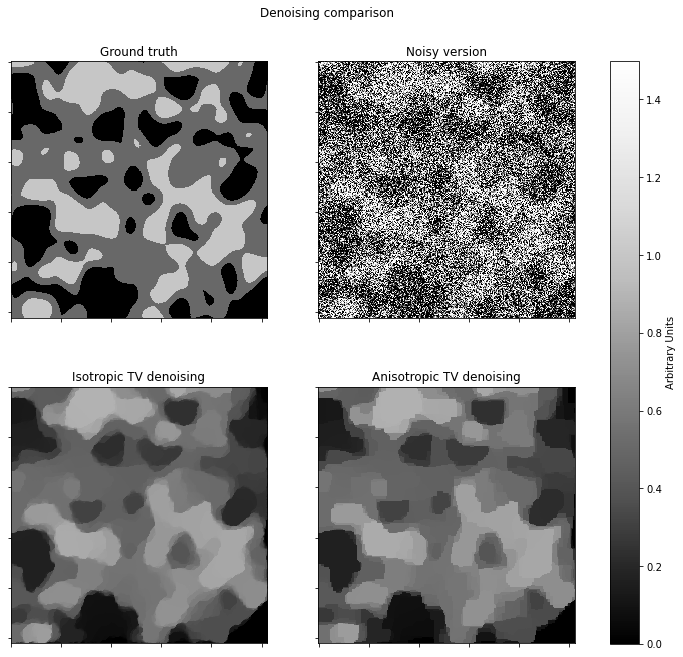

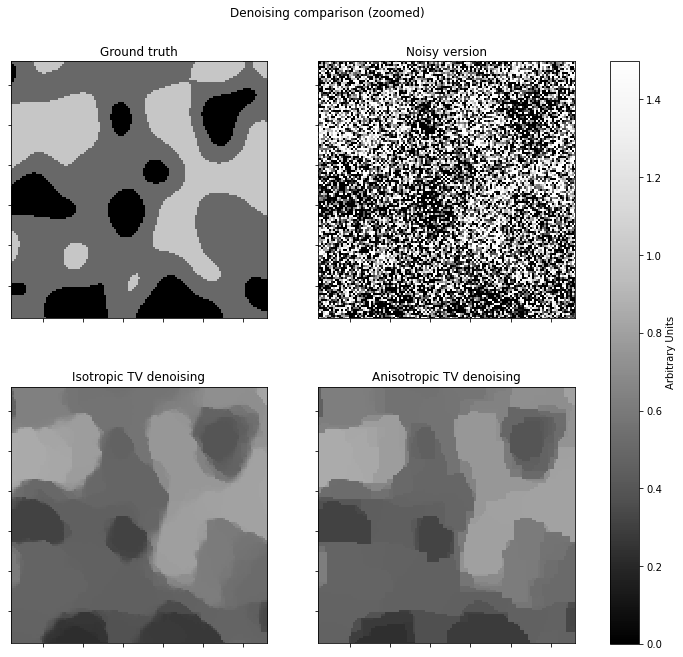

In [7]:
plt_args = dict(norm=plot.matplotlib.colors.Normalize(vmin=0, vmax=1.5))
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison")
fig.show()

# zoomed version
fig, ax = plot.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(11, 10))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0, 0], **plt_args)
plot.imview(y, title="Noisy version", fig=fig, ax=ax[0, 1], **plt_args)
plot.imview(x_iso, title="Isotropic TV denoising", fig=fig, ax=ax[1, 0], **plt_args)
plot.imview(x_aniso, title="Anisotropic TV denoising", fig=fig, ax=ax[1, 1], **plt_args)
ax[0, 0].set_xlim(N // 4, N // 4 + N // 2)
ax[0, 0].set_ylim(N // 4, N // 4 + N // 2)
fig.subplots_adjust(left=0.1, right=0.99, top=0.95, bottom=0.05, wspace=0.2, hspace=0.01)
fig.colorbar(
    ax[0, 0].get_images()[0], ax=ax, location="right", shrink=0.9, pad=0.05, label="Arbitrary Units"
)
fig.suptitle("Denoising comparison (zoomed)")
fig.show()